Look at the <a href="http://berkeleyearth.org/data/">Berkeley Earth</a> data to find global temperature values:
* `site_detail.txt` to identify the stations by latitude, longitude and elevation
* `data.txt` contains the data
>Date: The date of a measurement is expressed as a year and decimal fraction of a year corresponding to the midpoint of the time period being represented.  
>
>For example, in monthly data: 
>    January 2005 = 2005 + (1 - 0.5) / 12 = 2005.042
> 	June 2008 = 2008 + (6 - 0.5) / 12 = 2008.458
> 
>For example, in daily data: 
>	January 25, 2005 (Day 25) = 2005 + (25 - 0.5)/365 =2005.067
>	June 3, 2008 (Day 155) = 2008 + (155 - 0.5)/366 = 2008.422
>			[Note the use of 366, during leap years.]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Finding the coffee production schedule

In [2]:
# unformatted_coffee_production_seasons = pd.read_csv("../datasets/capstone/Coffee Producing Countries and Their Harvest Seasons.csv")

# coffee_production_seasons = pd.DataFrame()

# for i, row in enumerate(unformatted_coffee_production_seasons.index):
#     if unformatted_coffee_production_seasons["Producing Country"].isnull().loc[row]:
#         unformatted_coffee_production_seasons.loc[row, "Producing Country"] = unformatted_coffee_production_seasons.ix[i - 1, "Producing Country"]

# coffee_production_seasons = pd.concat(objs = [unformatted_coffee_production_seasons, 
#                   unformatted_coffee_production_seasons["Harvest Season"].str.split("-", expand = True)
#                  ], axis = 1)

# coffee_production_seasons.columns = ["Producing Country", 
#                                      "Coffee Type", 
#                                      "Harvest Season", 
#                                      "Harvest Begins", 
#                                      "Harvest Ends", 
#                                      "Year-round Harvest"]

# for row in coffee_production_seasons[~ coffee_production_seasons["Year-round Harvest"].isnull()].index:
#     coffee_production_seasons.iloc[row, 3] = coffee_production_seasons.iloc[row, 4].replace("Peak ", "")
#     coffee_production_seasons.iloc[row, 4] = coffee_production_seasons.iloc[row, 5]
#     coffee_production_seasons.iloc[row, 5] = True
    
# coffee_production_seasons.loc[:, "Year-round Harvest"] = coffee_production_seasons["Year-round Harvest"].map({None: False, True: True})

# coffee_production_seasons.drop("Harvest Season", axis = 1, inplace = True)

# coffee_production_seasons.to_csv("../datasets/capstone/coffee harvest schedule.csv")

coffee_harvest_schedule = pd.read_csv("../datasets/capstone/coffee harvest schedule.csv", index_col = 0)
coffee_harvest_schedule.head(8)

,Producing Country,Coffee Type,Harvest Begins,Harvest Ends,Year-round Harvest
0,Angola,Arabica,April,June,False
1,Angola,Robusta,May,September,False
2,Benin,Robusta,November,February,False
3,Bolivia,Arabica,April,August,False
4,Borneo,Arabica,June,December,False
5,Borneo,Robusta,May,December,False
6,Brazil,Arabica,April,September,False
7,Brazil,Robusta,April,September,False


### Defining functions

In [3]:
# Determining seasons by month
def get_season (month, hemisphere = None):
    northern_hemisphere_seasons = {1: 'Winter', 2: 'Winter', 3: 'Winter', 4: 'Spring', 5: 'Spring', 6: 'Spring', 7: 'Summer', 8: 'Summer', 9: 'Summer', 10: 'Fall', 11: 'Fall', 12: 'Fall'}
    southern_hemisphere_seasons = {7: 'Winter', 8: 'Winter', 9: 'Winter', 10: 'Spring', 11: 'Spring', 12: 'Spring', 1: 'Summer', 2: 'Summer', 3: 'Summer', 4: 'Fall', 5: 'Fall', 6: 'Fall'}

    if hemisphere.lower() == "northern":
        season = northern_hemisphere_seasons[month]
    elif hemisphere.lower() == "southern":
        season = southern_hemisphere_seasons[month]
    
    return season

In [4]:
# Converting date fraction to datetime
def convert_date_fraction_series_to_datetime(series = None):
    
    # Separate month decimal and year
    month_decimal = np.mod(series, 1)
    year = (series - month_decimal).astype(int)
    
    # Convert month decimal to month integer (1 = January, 2 = February, etc.)
    month = np.round(12 * month_decimal + 0.5).astype(int)
    
    # Concatenate the values together into a string
    date = year.astype(str) + "-" + month.astype(str) + "-01"
    
    # Convert the date strings into datetime values
    series = pd.to_datetime(date, yearfirst = True)
    
    return series

### Selecting weather stations by growing conditions

In [5]:
raw_station_data = pd.read_csv("../datasets/capstone/berkeley_earth_stations--site_detail.txt", 
                               delimiter = "\t", 
                               skiprows =148, 
                               names = ["Station ID", 
                                        "Station Name", 
                                        "Latitude", 
                                        "Longitude", 
                                        "Elevation (m)", 
                                        "Lat. Uncertainty", 
                                        "Long. Uncertainty", 
                                        "Elev. Uncertainty (m)", 
                                        "Country", 
                                        "State / Province Code", 
                                        "County", 
                                        "Time Zone", 
                                        "WMO ID", 
                                        "Coop ID", 
                                        "WBAN ID", 
                                        "ICAO ID", 
                                        "# of Relocations", 
                                        "# Suggested Relocations", 
                                        "# of Sources", 
                                        "Hash"])

### Cleaning station data

In [6]:
station_data = raw_station_data.copy()

# Select only relevant columns
station_data = station_data[["Station ID", "Station Name", "Latitude", "Longitude", "Elevation (m)", "Lat. Uncertainty", "Long. Uncertainty", "Elev. Uncertainty (m)", "Country"]]

# Convert values in numerical columns
numeric_columns_in_stations_data = ["Latitude", "Longitude", "Elevation (m)", "Lat. Uncertainty", "Long. Uncertainty", "Elev. Uncertainty (m)"]
station_data.loc[:, numeric_columns_in_stations_data] = station_data[numeric_columns_in_stations_data].apply(pd.to_numeric, errors = 'coerce')

# Remove whitespace from non-numerical columns
station_data.loc[:, "Station Name"] = station_data["Station Name"].str.strip()
station_data.loc[:, "Country"] = station_data["Country"].str.strip()

stations_in_coffee_producing_countries = station_data[station_data["Country"].isin(coffee_harvest_schedule["Producing Country"])]

hemisphere_dictionary = (station_data.groupby(by = "Country")["Latitude"].mean() > 0).map({True: "Northern", False: "Southern"}).to_dict()


Ideal coffee growing conditions:
* Arabica grows best in elevations 548 m – 1100 m for latitudes between 16° and 24°, or 1097 m – 1920 m for latitudes less that ±10°.
* Robusta grows best in elevations 0 m – 914 m in latitudes between ±10°.
* Arabica coffee’s optimal temperature range is 64°–70°F (18°C–21°C). It can tolerate mean annual temperatures up to roughly 73°F (24°C).
* **What about precipitation?**

I want data between 1989 and present.

In [7]:
# Arabica grows best in elevations 548 m – 1100 m for latitudes between 16° and 24°, or 1097 m – 1920 m for latitudes less that ±10°
arabica_growing_conditions_criteria = (stations_in_coffee_producing_countries["Elevation (m)"] >= 548) & (stations_in_coffee_producing_countries["Elevation (m)"] <= 1100) & (stations_in_coffee_producing_countries["Latitude"].abs() > 16) & (stations_in_coffee_producing_countries["Latitude"].abs() <= 24)
arabica_growing_conditions_criteria = arabica_growing_conditions_criteria | ((stations_in_coffee_producing_countries["Elevation (m)"] >= 1097) & (stations_in_coffee_producing_countries["Elevation (m)"] <= 1920) & (stations_in_coffee_producing_countries["Latitude"].abs() <= 10))

# Robusta grows best in elevations 0 m – 914 m in latitudes between ±10°
robusta_growing_conditions_criteria = (stations_in_coffee_producing_countries["Elevation (m)"] <= 914) & (stations_in_coffee_producing_countries["Latitude"].abs() <= 10)

# Select the stations in the ideal coffee growing regions
stations_in_arabica_conditions = stations_in_coffee_producing_countries[arabica_growing_conditions_criteria]["Station ID"]
stations_in_robusta_conditions = stations_in_coffee_producing_countries[robusta_growing_conditions_criteria]["Station ID"]

stations_in_arabica_conditions_dictionary = dict.fromkeys(stations_in_arabica_conditions.values, True)
stations_in_robusta_conditions_dictionary = dict.fromkeys(stations_in_robusta_conditions.values, True)


### Importing weather data

In [8]:
# Import raw temperature data from Berkeley Earth
raw_temperature_data = pd.read_csv("../datasets/capstone/berkeley_earth -- data.txt", 
            delimiter = "\t",  
            skiprows = 111, 
            names = ["Station ID", 
                     "Series Number", 
                     "Date", 
                     "Temperature (C)", 
                     "Uncertainty (C)", 
                     "Observations", 
                     "Time of Observation"])

### Cleaning weather data

In [9]:
temperatures_for_all_stations = raw_temperature_data.copy()

# Remove unnecessary labels
temperatures_for_all_stations.drop(labels = ["Series Number", "Uncertainty (C)", "Observations", "Time of Observation"], axis = 1, inplace = True)

# Select the temperature data for stations in coffee growing regions, and add country names
temperatures_for_coffee_producing_countries = temperatures_for_all_stations[temperatures_for_all_stations["Station ID"].isin(stations_in_coffee_producing_countries["Station ID"])]
temperatures_for_coffee_producing_countries = stations_in_coffee_producing_countries[["Station ID", "Country"]].merge(temperatures_for_coffee_producing_countries, on = "Station ID")

# Add columns indicating each station's hemisphere (for seasonality calculations later)
temperatures_for_coffee_producing_countries["Hemisphere"] = temperatures_for_coffee_producing_countries["Country"].map(hemisphere_dictionary)

# Designate stations in areas that grow arabica and robusta coffee
temperatures_for_coffee_producing_countries["Arabica Production"] = temperatures_for_coffee_producing_countries["Station ID"].map(stations_in_arabica_conditions_dictionary)
temperatures_for_coffee_producing_countries["Robusta Production"] = temperatures_for_coffee_producing_countries["Station ID"].map(stations_in_robusta_conditions_dictionary)
temperatures_for_coffee_producing_countries = temperatures_for_coffee_producing_countries.fillna(False)

# Keep the stations in areas that grow arabica or robusta coffee
temperature_data = temperatures_for_coffee_producing_countries[
    temperatures_for_coffee_producing_countries["Arabica Production"]
    | temperatures_for_coffee_producing_countries["Robusta Production"]]

# Drop the Station ID column since it's no longer needed
temperature_data.drop("Station ID", axis = 1, inplace = True)

# Convert dates to datetime values
temperature_data.loc[:, "Date"] = convert_date_fraction_series_to_datetime(temperature_data["Date"])

# Index by date
temperature_data.index = temperature_data["Date"].values
temperature_data = temperature_data.sort_index()
temperature_data = temperature_data.drop("Date", axis = 1)

# Add seasons columns
temperature_data["Season"] = temperature_data.index.month
temperature_data.loc[temperature_data["Hemisphere"] == "Northern", "Season"] = temperature_data[temperature_data["Hemisphere"] == "Northern"]["Season"].apply(lambda x: get_season(x, hemisphere = "Northern"))
temperature_data.loc[temperature_data["Hemisphere"] == "Southern", "Season"] = temperature_data[temperature_data["Hemisphere"] == "Southern"]["Season"].apply(lambda x: get_season(x, hemisphere = "Southern"))


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Visualizing stations in growing regions

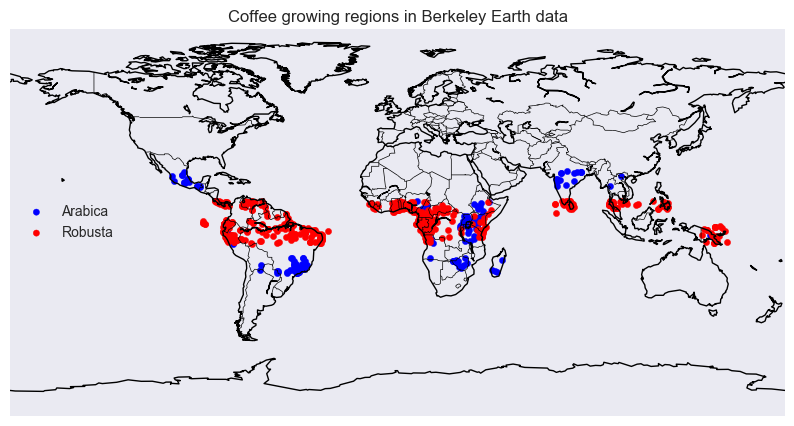

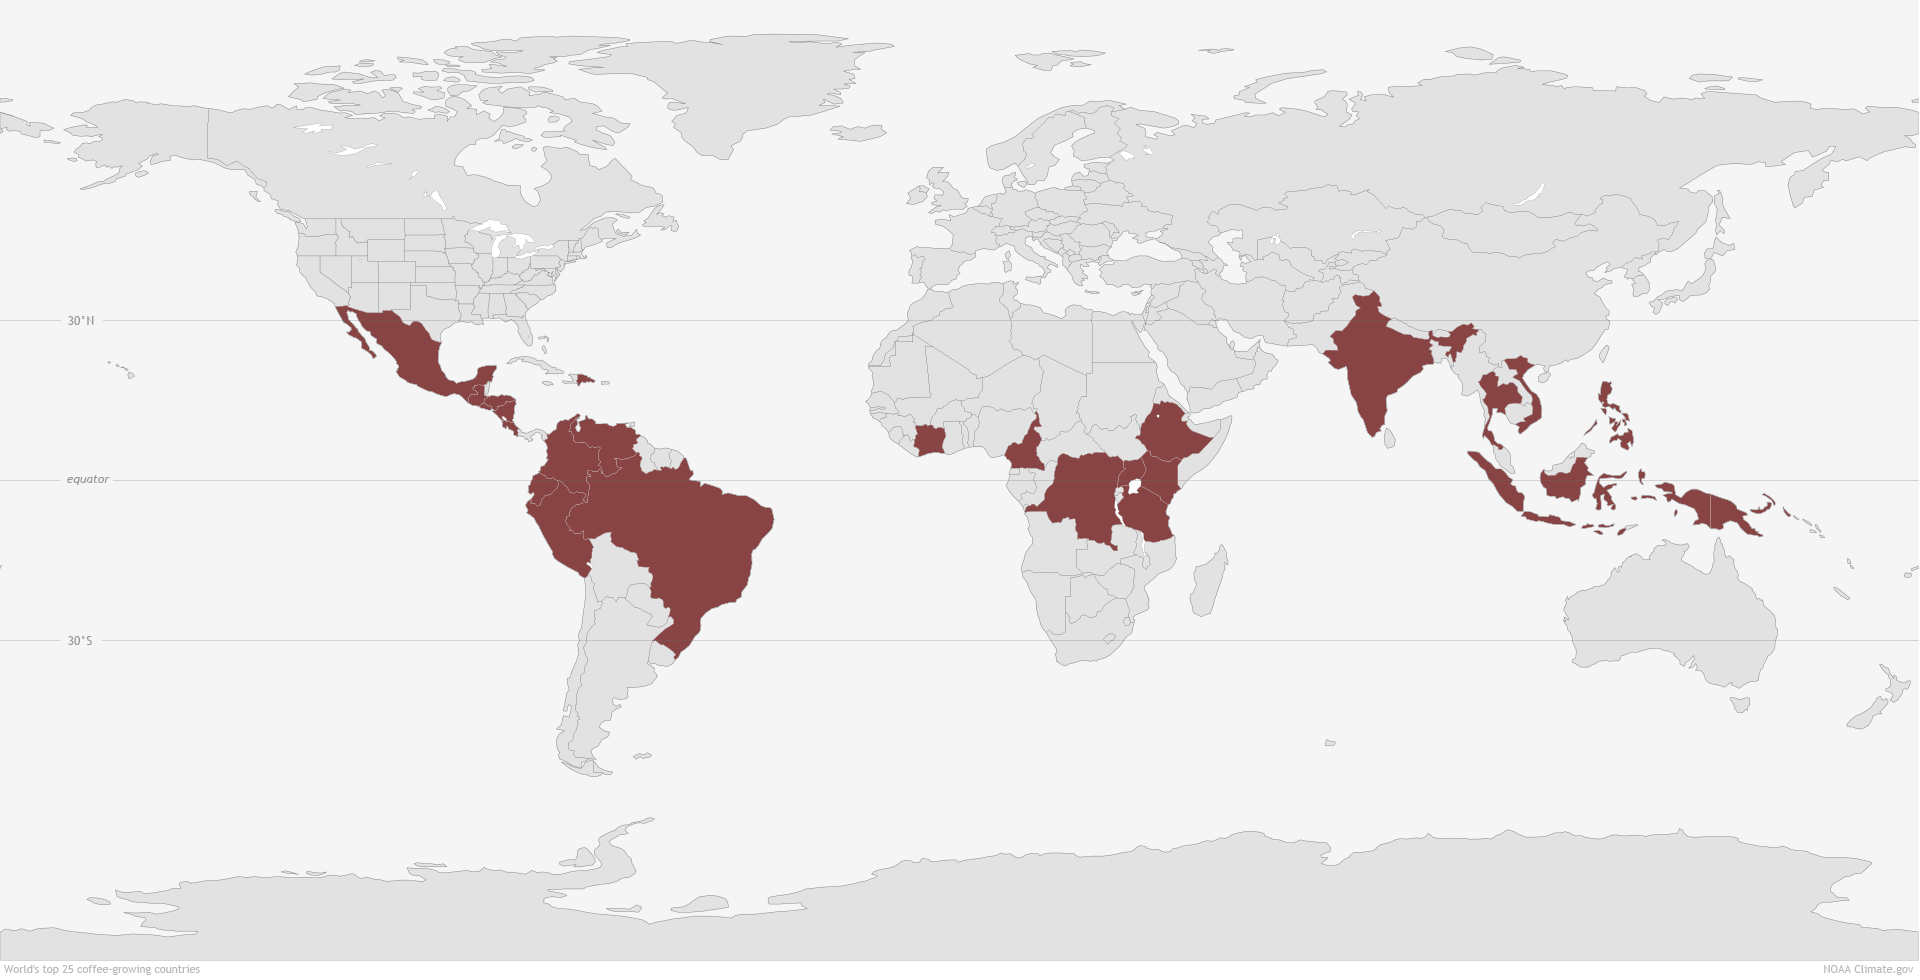

In [10]:
from mpl_toolkits.basemap import Basemap

arabica_producing_locations = pd.DataFrame(stations_in_arabica_conditions).merge(stations_in_coffee_producing_countries[["Station ID", "Latitude", "Longitude"]], on = "Station ID")
robusta_producing_locations = pd.DataFrame(stations_in_robusta_conditions).merge(stations_in_coffee_producing_countries[["Station ID", "Latitude", "Longitude"]], on = "Station ID")

arabica_longitudes = arabica_producing_locations["Longitude"].tolist()
arabica_latitudes = arabica_producing_locations["Latitude"].tolist()

robusta_longitudes = robusta_producing_locations["Longitude"].tolist()
robusta_latitudes = robusta_producing_locations["Latitude"].tolist()


fig = plt.figure(figsize = (10,16))
station_map = Basemap()

arabica_x, arabica_y = station_map(arabica_longitudes, arabica_latitudes)
station_map.scatter(arabica_x, arabica_y, color='b')

robusta_x, robusta_y = station_map(robusta_longitudes, robusta_latitudes)
station_map.scatter(robusta_x, robusta_y, color='r')


station_map.drawcoastlines()
station_map.drawcountries()

plt.title("Coffee growing regions in Berkeley Earth data")
plt.legend(["Arabica", "Robusta"], loc = 'center left')
plt.show()

from IPython.display import Image
Image("https://www.climate.gov/sites/default/files/CoffeeGrowingCountries_large.jpg")

### Exporting final temperatures dataframe

In [11]:
temperature_data_since_1990 = temperature_data[temperature_data.index.year > 1989]

# temperature_data_since_1990.to_csv("../datasets/capstone/temperature-in-coffee-growing-regions-since-1990--from-berkeley-earth.csv")

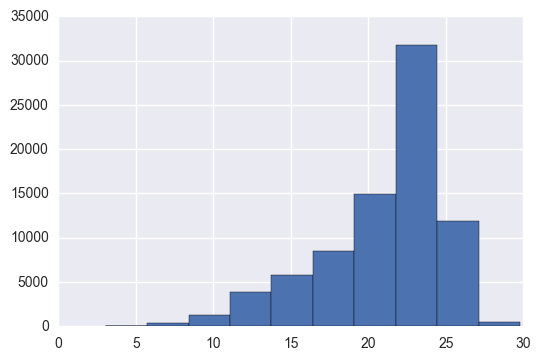

In [15]:
temperature_data_since_1990["Temperature (C)"].hist()
plt.show()

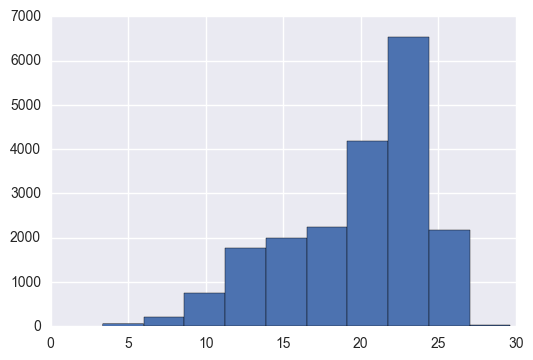

In [17]:
temperature_data_since_1990[temperature_data_since_1990["Season"] == "Winter"]["Temperature (C)"].hist()

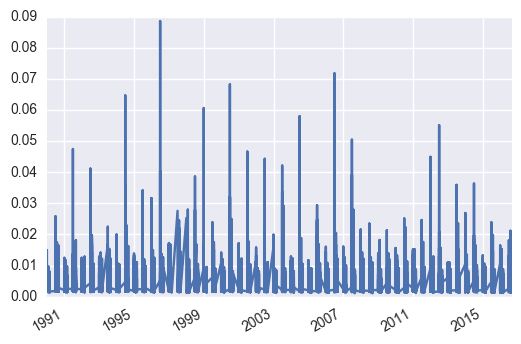

In [31]:
# (1 / temperature_data_since_1990[temperature_data_since_1990["Season"] == "Winter"]["Temperature (C)"] ** 1).plot()
(1 / temperature_data_since_1990[temperature_data_since_1990["Season"] == "Winter"]["Temperature (C)"] ** 2).plot()
plt.show()

In [46]:
temperature_data[(temperature_data.index.year == 1994) & (temperature_data.index.month == 7)].sort_values(by = "Temperature (C)")

,Country,Temperature (C),Hemisphere,Arabica Production,Robusta Production,Season
1994-07-01,Zimbabwe,3.933,Southern,True,False,Winter
1994-07-01,Zimbabwe,4.133,Southern,True,False,Winter
1994-07-01,Zimbabwe,5.293,Southern,True,False,Winter
1994-07-01,Zimbabwe,5.304,Southern,True,False,Winter
1994-07-01,Zimbabwe,5.785,Southern,True,False,Winter
1994-07-01,Zambia,7.077,Southern,True,False,Winter
1994-07-01,Zimbabwe,7.461,Southern,True,False,Winter
1994-07-01,Bolivia,7.763,Southern,True,False,Winter
1994-07-01,Brazil,9.590,Southern,True,False,Winter
1994-07-01,Bolivia,9.674,Southern,True,False,Winter
